Define classes

In [95]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import Cauchy

class ThinFilmLayer:
    """
    Class to represent a single layer in a thin film system.
    It encapsulates the layer's index of refraction 'n', extinction coefficient 'k', 
    and thickness. n and k vary with wavelength.
    """
    
    @staticmethod
    def find_file_insensitive(path, filename):
        """
        Search for a file in the specified path in a case-insensitive manner.

        Parameters:
        path : str
            The directory path where to look for the file.
        filename : str
            The name of the file to look for.

        Returns:
        str or None
            The name of the file with the original case if found, None otherwise.
        """
        filename_lower = filename.lower()
        for file in os.listdir(path):
            if file.lower() == filename_lower:
                return file
        return None

    def __init__(self, material, thickness, n_points, min_wavelength, max_wavelength):
        """
        Initialize the layer with the chosen material's properties.
        
        Parameters:
        material : str
            Name of the material where its n, k are extracted.
        thickness : float
            Thickness of the material chosen [nm].
        n_points: int
            Number of points for spline fitting.
            If n_points == 0, then use all the n and k data within the wavelength range.
        min_wavelength: float
            Lower bound of the wavelength used to fit for n and k.
        max_wavelength: float
            Upper bound of the wavelength used to fit for n and k.
        """
        self.material = material
        self.thickness = thickness
        
        # check if a file with material name exists
        path = r"D:\OneDrive - Cornell University\Hongrui\Cornell\Master's project\Code\Reflectance Fitting\tfoc\database.nk\database_nk"
        filename = self.find_file_insensitive(path, f"{material}.csv")
        if filename is not None:
            # if yes, read the file
            data = pd.read_csv(os.path.join(path, filename))
            print(f"nk data found for {material}.")

            # If n_points != 0, select n points with approximately equal spacing
            # (If n_points == 0, use all the data points)
            if n_points != 0:
                indices = np.linspace(0, len(data) - 1, n_points, dtype=int)
                data = data.iloc[indices]
            
            photon_energy = data.iloc[:, 0].values
            wavelength = 1239.8419843320021 / photon_energy # an array of wavelengths
            n = data.iloc[:, 1].values
            k = data.iloc[:, 2].values

            # Sort wavelength, n, and k in ascending order for spline fitting
            sorted_indices = np.argsort(wavelength)
            wavelength = wavelength[sorted_indices]
            n = n[sorted_indices]
            k = k[sorted_indices]

        else:
            # if the file does not exist, generate n and k
            wavelength = np.linspace(min_wavelength, max_wavelength, n_points)
            n = np.random.uniform(1.4, 2.0, n_points)
            k = np.random.uniform(0.0, 0.2, n_points)
            print(f"nk data not found for {material}.")

        # Filtering the data based on wavelength range before creating the spline representation
        indices = (wavelength >= min_wavelength) & (wavelength <= max_wavelength)
        wavelength = wavelength[indices]
        n = n[indices]
        k = k[indices]

        self.wavelength = wavelength
        self.n = n
        self.k = k
        
        # Generate spline representation of n and k
        # if len(wavelength) < 4: # Linear interpolation
        #     self.n_spline = mySpline.fit_spline(wavelength, n, opts=1)
        #     self.k_spline = mySpline.fit_spline(wavelength, k, opts=1)
        # Cubic spline interpolation
        self.n_spline_cubic = CubicSpline(wavelength, n)
        self.k_spline_cubic = CubicSpline(wavelength, k)

        # Univariate spline interpolation
        # self.n_spline_univariate = UnivariateSpline(wavelength, n, k=3)
        # self.k_spline_univariate = UnivariateSpline(wavelength, k, k=3)
        
        # B-spline interpolation
        # self.n_spline_Bspline = BSpline(wavelength, n, k=3)
        # self.k_spline_Bspline = BSpline(wavelength, k, k=3)

        # Cauchy
        # self.n_spline_cauchy = Cauchy.cauchy(wavelength, n)
        # self.k_spline_cauchy = Cauchy.cauchy(wavelength, k)

    def get_n(self, wavelength):
        """
        Returns the index of refraction at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the index of refraction.
        """
        return self.n_spline_cubic(wavelength)

    def get_k(self, wavelength):
        """
        Returns the extinction coefficient at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the extinction coefficient.
        """
        return self.k_spline_cubic(wavelength)
    
    def get_N(self, wavelength):
        """
        Returns the refractive index at the specified wavelength using spline interpolation.

        Parameter:
        wavelength : float
            The wavelength [nm] at which to get the refractive index.
        """
        return self.get_n(wavelength) + 1j * self.get_k(wavelength)

    def set_n(self, wavelength, new_n_value):
        """
        Sets the refractive index at the specified wavelength and updates the spline representation.

        Parameters:
        wavelength : float
            The wavelength [nm] at which to set the index of refraction.
        new_n_value : float
            The new index of refraction value.
        """
        idx = (np.abs(self.wavelength - wavelength)).argmin()  # find the closest wavelength
        self.n[idx] = new_n_value

        # Update the spline representation
        # if len(self.wavelength) < 4:
        #     self.n_spline = make_interp_spline(self.wavelength, self.n, k=1)
        # else:
        original_n_spline_cubic = CubicSpline(self.wavelength, self.n)
        self.n_spline_cubic = lambda x: np.maximum(original_n_spline_cubic(x), 0)


    def set_k(self, wavelength, new_k_value):
        """
        Sets the extinction coefficient at the specified wavelength and updates the spline representation.
        
        Parameters:
        wavelength : float
            The wavelength [nm] at which to set the extinction coefficient.
        new_k_value : float
            The new extinction coefficient value.
        """
        idx = (np.abs(self.wavelength - wavelength)).argmin()  # find the closest wavelength
        self.k[idx] = new_k_value

        # Update the spline representation
        # if len(self.wavelength) < 4:
        #     self.k_spline = make_interp_spline(self.wavelength, self.k, k=1)
        # else:
        original_k_spline_cubic = CubicSpline(self.wavelength, self.k)
        self.k_spline_cubic = lambda x: np.maximum(original_k_spline_cubic(x), 0)

    def plot_n(self, min_wavelength, max_wavelength):
        """
        Plots the index of refraction as a function of wavelength.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        plt.figure()
        plt.plot(wavelengths, self.n_spline_cubic(wavelengths), '-', label='n spline cubic')
        # plt.plot(wavelengths, self.n_spline_univariate(wavelengths), '-', label='n spline univariate')
        # plt.plot(wavelengths, self.n_spline_Bspline(wavelengths), '-', label='n spline Bspline')
        # plt.plot(wavelengths, self.n_spline_cauchy(wavelengths), '-', label='n spline cauchy')
        plt.scatter(self.wavelength, self.n, marker='o', color='r', label='n data')
        plt.xlabel('Wavelength (λ) [nm]')
        plt.ylabel('Refractive index (n)')
        plt.title(f'Refractive index vs wavelength for {self.material}')
        plt.legend()
        plt.show()

    def plot_k(self, min_wavelength, max_wavelength):
        """
        Plots the extinction coefficient as a function of wavelength.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        plt.figure()
        plt.plot(wavelengths, self.k_spline_cubic(wavelengths), '-', label='k spline cubic')
        # plt.plot(wavelengths, self.k_spline_univariate(wavelengths), '-', label='k spline univariate')
        # plt.plot(wavelengths, self.k_spline_Bspline(wavelengths), '-', label='k spline Bspline')
        # plt.plot(wavelengths, self.k_spline_cauchy(wavelengths), '-', label='n spline cauchy')
        plt.scatter(self.wavelength, self.k, marker='o', color='r', label='k data')
        plt.xlabel('Wavelength (λ) [nm]')
        plt.ylabel('Extinction coefficient (k)')
        plt.title(f'Extinction coefficient vs wavelength for {self.material}')
        plt.legend()
        plt.show()

    def plot_nk(self, min_wavelength, max_wavelength):
        """
        Plots the index of refraction and extinction coefficient as functions of wavelength,
        both for the input data and the spline interpolation.
        """
        wavelengths = np.linspace(min_wavelength, max_wavelength, num=1000)
        n_values = self.n_spline(wavelengths)
        k_values = self.k_spline(wavelengths)

        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Wavelength (λ) [nm]')
        ax1.set_ylabel('Refractive index (n)', color='tab:blue')
        ax1.plot(wavelengths, n_values, '-', color='tab:blue', label='n spline')
        ax1.scatter(self.wavelength, self.n, marker='o', color='r', label='n data')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()  
        ax2.set_ylabel('Extinction coefficient (k)', color='tab:red')  
        ax2.plot(wavelengths, k_values, '-', color='tab:red', label='k spline')
        ax2.scatter(self.wavelength, self.k, marker='o', color='r', label='k data')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        fig.tight_layout()  
        plt.title(f'Refractive index and extinction coefficient vs wavelength for {self.material}')
        fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        plt.show()

    

class ThinFilmSystem:
    """
    Class to represent a thin film system composed of multiple layers.
    """
    def __init__(self, layers):
        """
        Initialize the system with a list of ThinFilmLayer objects.
        layers : list of ThinFilmLayer
            Layers of the system in order from the top layer to the substrate.
        """
        self.layers = layers

    def add_layer(self, layer):
        """
        Add a layer to the system. The new layer is added to the top of the stack.

        Parameters:
        layer : ThinFilmLayer
            The layer to add. This should be an instance of the ThinFilmLayer class.
        """
        self.layers.insert(0, layer)
    
    def calculate_propagation_matrix(self, wavelength, layer_index):
        """
        Calculate the propagation matrix for this layer for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the propagation matrix of this layer.
        layer_index: int
            Index of the layer to be calculated in the multilayer system.

        Returns:
        P : 2D array
            Propagation matrix of this layer.
        """
        N = self.layers[layer_index].get_N(wavelength)
        thickness = self.layers[layer_index].thickness
        phase = 2 * np.pi * N * thickness / wavelength
        P = np.array([[np.exp(1j * phase.real) * np.exp(-phase.imag), 0], 
                      [0, np.exp(-1j * phase.real) * np.exp(phase.imag)]])
        return P
    
    def calculate_boundary_matrix(self, wavelength, layer_index):
        """
        Calculate the boundary matrix for two adjacent layers ("this" layer and "next" layer) 
        in the multilayer system for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the boundary matrix of this layer.
        layer_index: int
            Index of the layer to be calculated in the multilayer system.
        
        Returns:
        B : 2D array
            Boundary matrix of the boundary between this layer and the next layer.
        """
        N_this = self.layers[layer_index].get_N(wavelength)
        N_next = self.layers[layer_index + 1].get_N(wavelength)
        B = 1 / (2 * N_this) * np.array([[N_this + N_next, N_this - N_next],
                                         [N_this - N_next, N_this + N_next]])
        B = np.conjugate(B)
        return B
    
    def calculate_total_transfer_matrix(self, wavelength):
        """
        Calculate the total transfer matrix for the multilayer system 
        for a particular wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)

        Parameters:
        wavelength : float
            Wavelength [nm] at which to calculate the transfer matrix of this layer.
        
        Returns:
        M_total : 2D array
            Total transfer matrix of the multilayer system.
        """
        M = np.eye(2) # create an identity matrix
        B01 = self.calculate_boundary_matrix(wavelength, 0) # The boundary matrix between air and the first layer
        M = M @ B01
        for index in range(1, len(self.layers) - 1):
            P = self.calculate_propagation_matrix(wavelength, index)
            B = self.calculate_boundary_matrix(wavelength, index)
            M = M @ P @ B
        return M
    
    def print_matrices(self, wavelength):
        """
        Print the boundary matrices, propagation matrices, and their multiplications for the multilayer system 
        for a particular wavelength.

        Parameter:
        wavelength: float
            Wavelength of the light at which matrices are printed.
        """
        # Print the boundary matrix between air and the first layer
        B01 = self.calculate_boundary_matrix(wavelength, 0)
        print(f"B01 = {B01}")

        # Print the matrices for the rest layers, and their multiplication
        M = np.eye(2) # create an identity matrix
        M = B01 @ M
        print(f"M = {M}")

        for index in range(1, len(self.layers) - 1):
            P = self.calculate_propagation_matrix(wavelength, index)
            print(f"P{index} = {P}")
            M = M @ P
            print(f"M = {M}")
            B = self.calculate_boundary_matrix(wavelength, index)
            print(f"B{index}{index + 1} = {B}")
            M = M @ B
            print(f"M = {M}")
            M_cal = self.calculate_total_transfer_matrix(wavelength)
            print(f"M_cal = {M_cal}")

    def print_N(self, wavelength):
        """
        Print N for each layer in the multilayer system.
        
        Parameter:
        wavelength: float
            Wavelength of the light at which N are calculated and printed.
        """
        for layer in self.layers:
            index = self.layers.index(layer)
            print(f"N_{index} = {layer.get_N(wavelength)}")

    def calculate_RTA(self, wavelength_range):
        """
        Calculate the reflectance (R), transmittance (T), and absorption (A)
        for a multilayer system as a function of wavelength.
        Assume the incident light is normal (or the calculation would be very complicated...)
        Can add the non-normal part later using Snell's law: N1cos(θ1) = N2cos(θ2)
        
        Parameters:
        wavelength_range : array-like
            Range of wavelengths [nm] for which R, T, A should be calculated.
        
        Returns:
        R : array-like
            Reflectance of the multilayer system for each wavelength in wavelength_range.
        T : array-like
            Transmittance of the multilayer system for each wavelength in wavelength_range.
        A : array-like
            Absorption of the multilayer system for each wavelength in wavelength_range.
        """
        R = []
        T = []
        A = []
        for wavelength in wavelength_range:
            M = self.calculate_total_transfer_matrix(wavelength)
            # Calculate R
            r = M[1, 0] / M[0, 0]
            R_value = np.abs(r)**2
            R.append(np.clip(R_value, 0, 1)) # np.clip is used to restrict the value within [0, 1]

            # Calculate T
            n0 = self.layers[0].get_n(wavelength) # n of the incident medium, which is usually air
            ns = self.layers[-1].get_n(wavelength) # n of the substrate
            t = 1 / M[0, 0]
            T_value = np.abs(t)**2 * (ns / n0) # (ns / n0) corrects for the index of the substrate
            T.append(np.clip(T_value, 0, 1))

            # Calulate A
            A_value = 1 - R[-1] - T[-1]
            A.append(np.clip(A_value, 0, 1))

        return np.array(R), np.array(T), np.array(A)
    
    def calculate_RTA_single(self, wavelength):
        """
        Calculate the reflectance (R), transmittance (T), and absorption (A)
        for a multilayer system for a single wavelength.

        Parameters:
        wavelength: float
            Wavelength of the light to calculate R, T, A.

        Returns:
        R : float
            Reflectance of the multilayer system for this wavelength.
        T : float
            Transmittance of the multilayer system for this wavelength.
        A : float
            Absorption of the multilayer system for this wavelength.
        """
        M = self.calculate_total_transfer_matrix(wavelength)
        # Calculate R
        r = M[1, 0] / M[0, 0]
        R = np.abs(r)**2
        R = np.clip(R, 0, 1) # np.clip is used to restrict the value within [0, 1]

        # Calculate T
        n0 = self.layers[0].get_n(wavelength) # n of the incident medium, which is usually air
        ns = self.layers[-1].get_n(wavelength) # n of the substrate
        t = 1 / M[0, 0]
        T = np.abs(t)**2 * (ns / n0) # (ns / n0) corrects for the index of the substrate
        T = np.clip(T, 0, 1)

        # Calculate A
        A = 1 - R - T
        A = np.clip(A, 0, 1)

        return R, T, A

    def plot_RTA(self, wavelength_range):
        """
        Plot the reflectance (R), transmittance (T), and absorption (A)
        for the multilayer system as a function of wavelength.
        Assume the incident light is normal.

        Parameters:
        wavelength_range : array-like
            Range of wavelengths [nm] for which R, T, A should be plotted.
        theta_deg : float
            Angle of incidence within the medium [degrees].
        """
        # Calculate RTA
        R, T, A = self.calculate_RTA(wavelength_range)

        # Generate the plot
        plt.figure(figsize=(10, 6))

        plt.plot(wavelength_range, R, label='Reflectance')
        plt.plot(wavelength_range, T, label='Transmittance')
        plt.plot(wavelength_range, A, label='Absorption')

        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Magnitude')
        plt.title('RTA vs Wavelength for Thin Film System')
        plt.legend()

380
830
nk data found for air.
nk data found for igzo_111.
nk data found for sio2.
nk data found for c-Si.


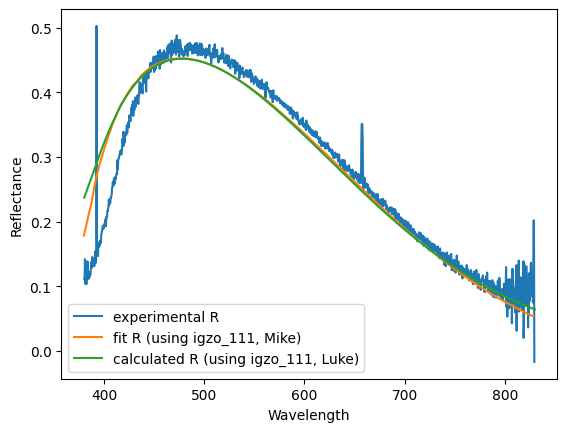

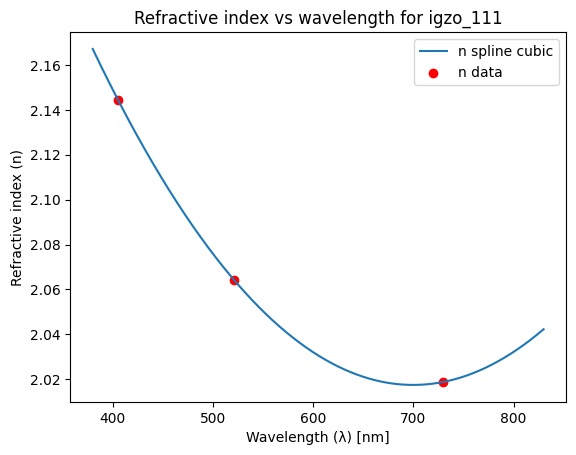

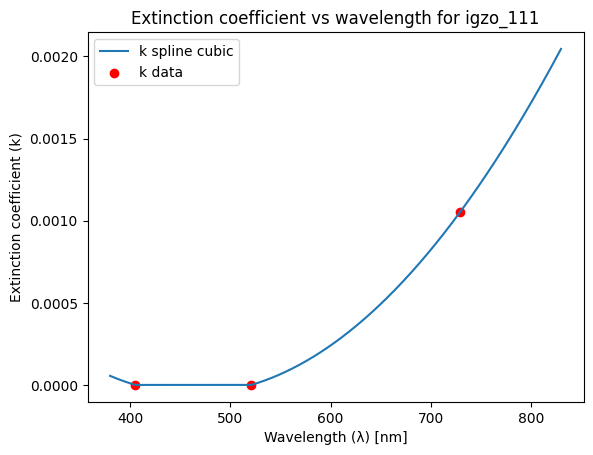

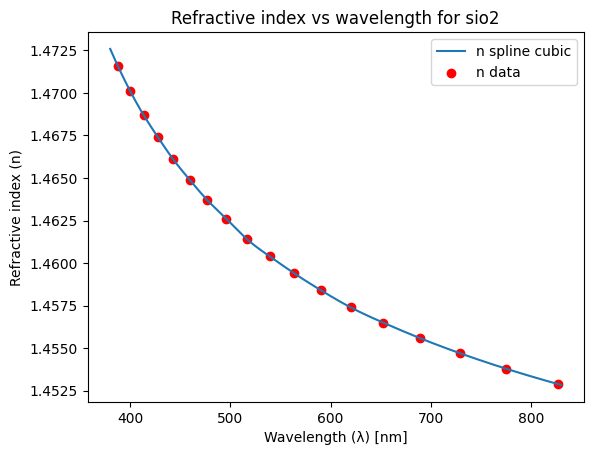

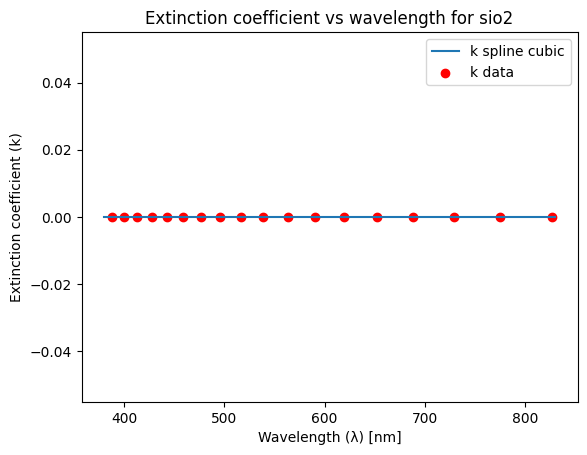

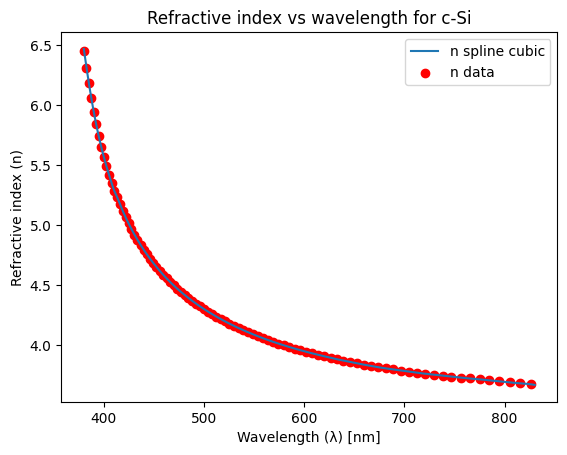

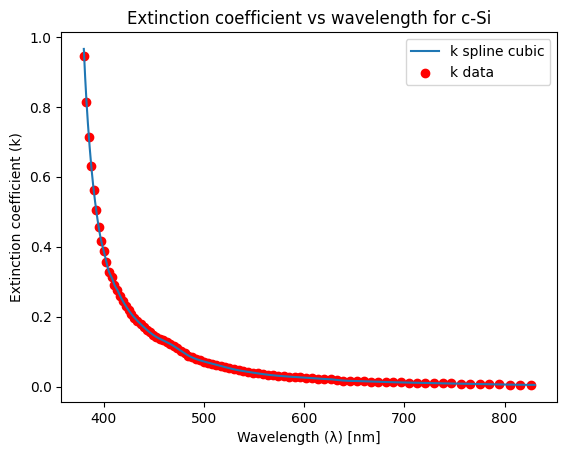

In [96]:
# Experimental data
path = r"D:\OneDrive - Cornell University\Hongrui\Cornell\Master's project\Code\Reflectance Fitting\tfoc\database.nk\test_data\test_data\spectra\+02_+05.csv"
data = pd.read_csv(path, names=['# lambda', 'reflectance', 'uncertainty', 'raw', 'dark', 'reference', 'fit'], skiprows=13)
data = data.rename(columns={'# lambda': 'wavelength'})

# Fit data from Mike's tfoc
path = r"D:\OneDrive - Cornell University\Hongrui\Cornell\Master's project\Code\Reflectance Fitting\fit_from_tfoc\film.csv"
tfoc_fit = pd.read_csv(path, names=['wavelength', 'R', 'T (into substrate)'], skiprows=1)


# Define layers
l = 380 # left
r = 830 # right
index_l = np.abs(data['wavelength'] - l).argmin()
index_r = np.abs(data['wavelength'] - r).argmin()
index_tfoc_l = np.abs(tfoc_fit['wavelength'] - l).argmin()
index_tfoc_r = np.abs(tfoc_fit['wavelength'] - r).argmin()

wavelength_range = np.linspace(l, r, 1000)
print(l)
print(r)

air = ThinFilmLayer("air", 1, 0, l, r)
layer1 = ThinFilmLayer("igzo_111", 100, 5, l, r)
layer2 = ThinFilmLayer("sio2", 21.5, 0, l, r)
substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

layer1.set_k(400, 0.0)
layer1.set_k(420, 0.0)
layer1.set_k(440, 0)

# Create multilayer system
multilayer = ThinFilmSystem([air, layer1, layer2, substrate])
R, _, _ = multilayer.calculate_RTA(wavelength_range)

# # Plot the result
plt.figure()
plt.plot(data['wavelength'][index_l:index_r], data['reflectance'][index_l:index_r], label='experimental R')
plt.plot(tfoc_fit['wavelength'][index_tfoc_l:index_tfoc_r], tfoc_fit['R'][index_tfoc_l:index_tfoc_r], label='fit R (using igzo_111, Mike)')
plt.plot(wavelength_range, R, label='calculated R (using igzo_111, Luke)')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

layer1.plot_n(l, r)
layer1.plot_k(l, r)
layer2.plot_n(l, r)
layer2.plot_k(l, r)
substrate.plot_n(l, r)
substrate.plot_k(l, r)
# layer1.plot_nk(l, r)

Process the test data

In [97]:
# # Reading csv data
# path = r"D:\OneDrive - Cornell University\Hongrui\Cornell\Master's project\Code\tfoc\database.nk\test_data\test_data\spectra"
# path2 = r"D:\OneDrive - Cornell University\Hongrui\Cornell\Master's project\Code\tfoc\database.nk\database_nk"


# # Custom function to parse layer information from the file
# def parse_layer_info(path):
#     layer_data = []
#     with open(path, 'r') as file:
#         lines = file.readlines()
#         sample_stack_start = lines.index("# SAMPLE STACK\n") + 1
#         for line in lines[sample_stack_start:]:
#             if line.strip() == "# END":
#                 break
#             layer_info = line.strip().split()
#             layer_data.append((layer_info[1].strip('"'), float(layer_info[2])))
#     return layer_data

# def extract_thickness(path):
#     """
#     This function extracts the thickness of b-Ga2O3 and SiO2 from the file.
    
#     Parameters:
#     path : str
#         The path to the .csv file.
        
#     Returns:
#     A dictionary where keys are the material names and values are their thicknesses.
#     """
#     thicknesses = {"b-Ga2O3": None, "SiO2": None}
    
#     with open(path, 'r') as file:
#         lines = file.readlines()  # Read all lines
        
#     b_Ga2O3_line = lines[8]  # 9th line (index starts from 0)
#     SiO2_line = lines[9]  # 10th line
    
#     # Extract the thickness (the third element of the line)
#     thicknesses["b-Ga2O3"] = float(b_Ga2O3_line.split()[3])
#     thicknesses["SiO2"] = float(SiO2_line.split()[3])
    
#     return thicknesses


# filename = r"D:\OneDrive - Cornell University\Hongrui\Cornell\Master's project\Code\tfoc\database.nk\test_data\test_data\spectra\+00_+00.csv"
# print(extract_thickness(filename))

# def process_file(path):
#     # Extract layer thicknesses from file
#     thicknesses = extract_thickness(path)

#     # Read the data
#     data = pd.read_csv(path, names=['# lambda', 'reflectance', 'uncertainty', 'raw', 'dark', 'reference', 'fit'], skiprows=13)
#     data = data.rename(columns={'# lambda': 'wavelength'})

#     # Define layers
#     l = min(data['wavelength']) # left
#     r = max(data['wavelength']) # right
#     air = ThinFilmLayer("air", 1, 0, l, r)
#     layer1 = ThinFilmLayer("b-Ga2O3", thicknesses["b-Ga2O3"], 0, l, r)
#     layer2 = ThinFilmLayer("SiO2", thicknesses["SiO2"], 0, l, r)
#     substrate = ThinFilmLayer("c-Si", 1, 0, l, r)

#     # Create multilayer system
#     multilayer = ThinFilmSystem([air, layer1, layer2, substrate])

#     # Calculate the reflectance
#     wavelength_range = np.linspace(l, r, 1000)
#     R, T, A = multilayer.calculate_RTA(wavelength_range)

#     # Plot
#     plt.figure()
#     plt.plot(data['wavelength'], data['reflectance'], label='experimental R')
#     plt.plot(data['wavelength'], data['fit'], label='fit R')
#     plt.plot(wavelength_range, R, label='calculated R')
#     plt.xlabel('Wavelength')
#     plt.ylabel('Reflectance')
#     plt.legend()
    
#     # Extract filename without extension
#     file_name = Path(path).stem
#     plt.title(f'{file_name} (b-Ga2O3 thickness: {thicknesses["b-Ga2O3"]})')
    
#     # Save the figure
#     your_directory = r"D:\OneDrive - Cornell University\Hongrui\Cornell\Master's project\Code\tfoc\database.nk\test_data\test_data\test_plot"
#     plt.savefig(f'{your_directory}/{file_name}.png', dpi=300)
#     plt.close()

# # Find all CSV files in the directory
# files = glob.glob(path + '/*.csv')

# # Process all files
# for file in files:
#     process_file(file)



Test the matrix output

In [98]:
layer3 = ThinFilmLayer("sio2", 1000, 0, l, r)
multilayer2 = ThinFilmSystem([air, layer3, substrate])
multilayer2.print_matrices(500)
multilayer2.print_N(500)
print(multilayer2.calculate_RTA_single(500))

nk data found for sio2.
B01 = [[ 1.23101215+7.30844053e-09j -0.23101215-7.30844053e-09j]
 [-0.23101215-7.30844053e-09j  1.23101215+7.30844053e-09j]]
M = [[ 1.23101215+7.30844053e-09j -0.23101215-7.30844053e-09j]
 [-0.23101215-7.30844053e-09j  1.23101215+7.30844053e-09j]]
P1 = [[0.89020964-0.45555108j 0.        +0.j        ]
 [0.        +0.j         0.89020964+0.45555108j]]
M = [[ 1.09585889-0.56078891j -0.20564924-0.10523784j]
 [-0.20564924+0.10523783j  1.09585888+0.56078893j]]
B12 = [[ 1.97022309-0.02465795j -0.97022309+0.02465795j]
 [-0.97022309+0.02465795j  1.97022309-0.02465795j]]
M = [[ 2.34737917-1.0348676j  -1.45716952+0.36884085j]
 [-1.47963544-0.30465585j  2.36984507+0.9706826j ]]
M_cal = [[ 2.34737917-1.0348676j  -1.45716952+0.36884085j]
 [-1.47963544-0.30465585j  2.36984507+0.9706826j ]]
N_0 = (1.00023+1e-08j)
N_1 = (1.4623605589061484+0j)
N_2 = (4.299992524170369+0.0721176252049972j)
(0.34676913698570877, 0.6532308698394096, 0.0)
